# ⏱ High-level `TimedModule` API

## Constructing a `TimedModule`

In [1]:
# - Switch off warnings
import warnings
warnings.filterwarnings('ignore')

# - Useful imports
import numpy as np

try:
    from rich import print
except:
    pass

from rockpool.nn.combinators import Sequential
from rockpool.nn.modules import Rate, Linear

# - Construct the TimedModule
Nin = 1
Nout = 5
dt = 1e-3
tmod = Sequential(Linear((Nin, Nout)), Rate(Nout)).timed(dt = dt)
print(tmod)

Could not import package: No module named 'iaf_nest'


TimedModuleWrapper  with shape (1, 5) {
    ModSequential '_module' with shape (1, 5) {
        Linear '0_Linear' with shape (1, 5)
        Rate '1_Rate' with shape (5,)
    }
} with ModSequential '_module' as module

## Evolving a `TimedModule`

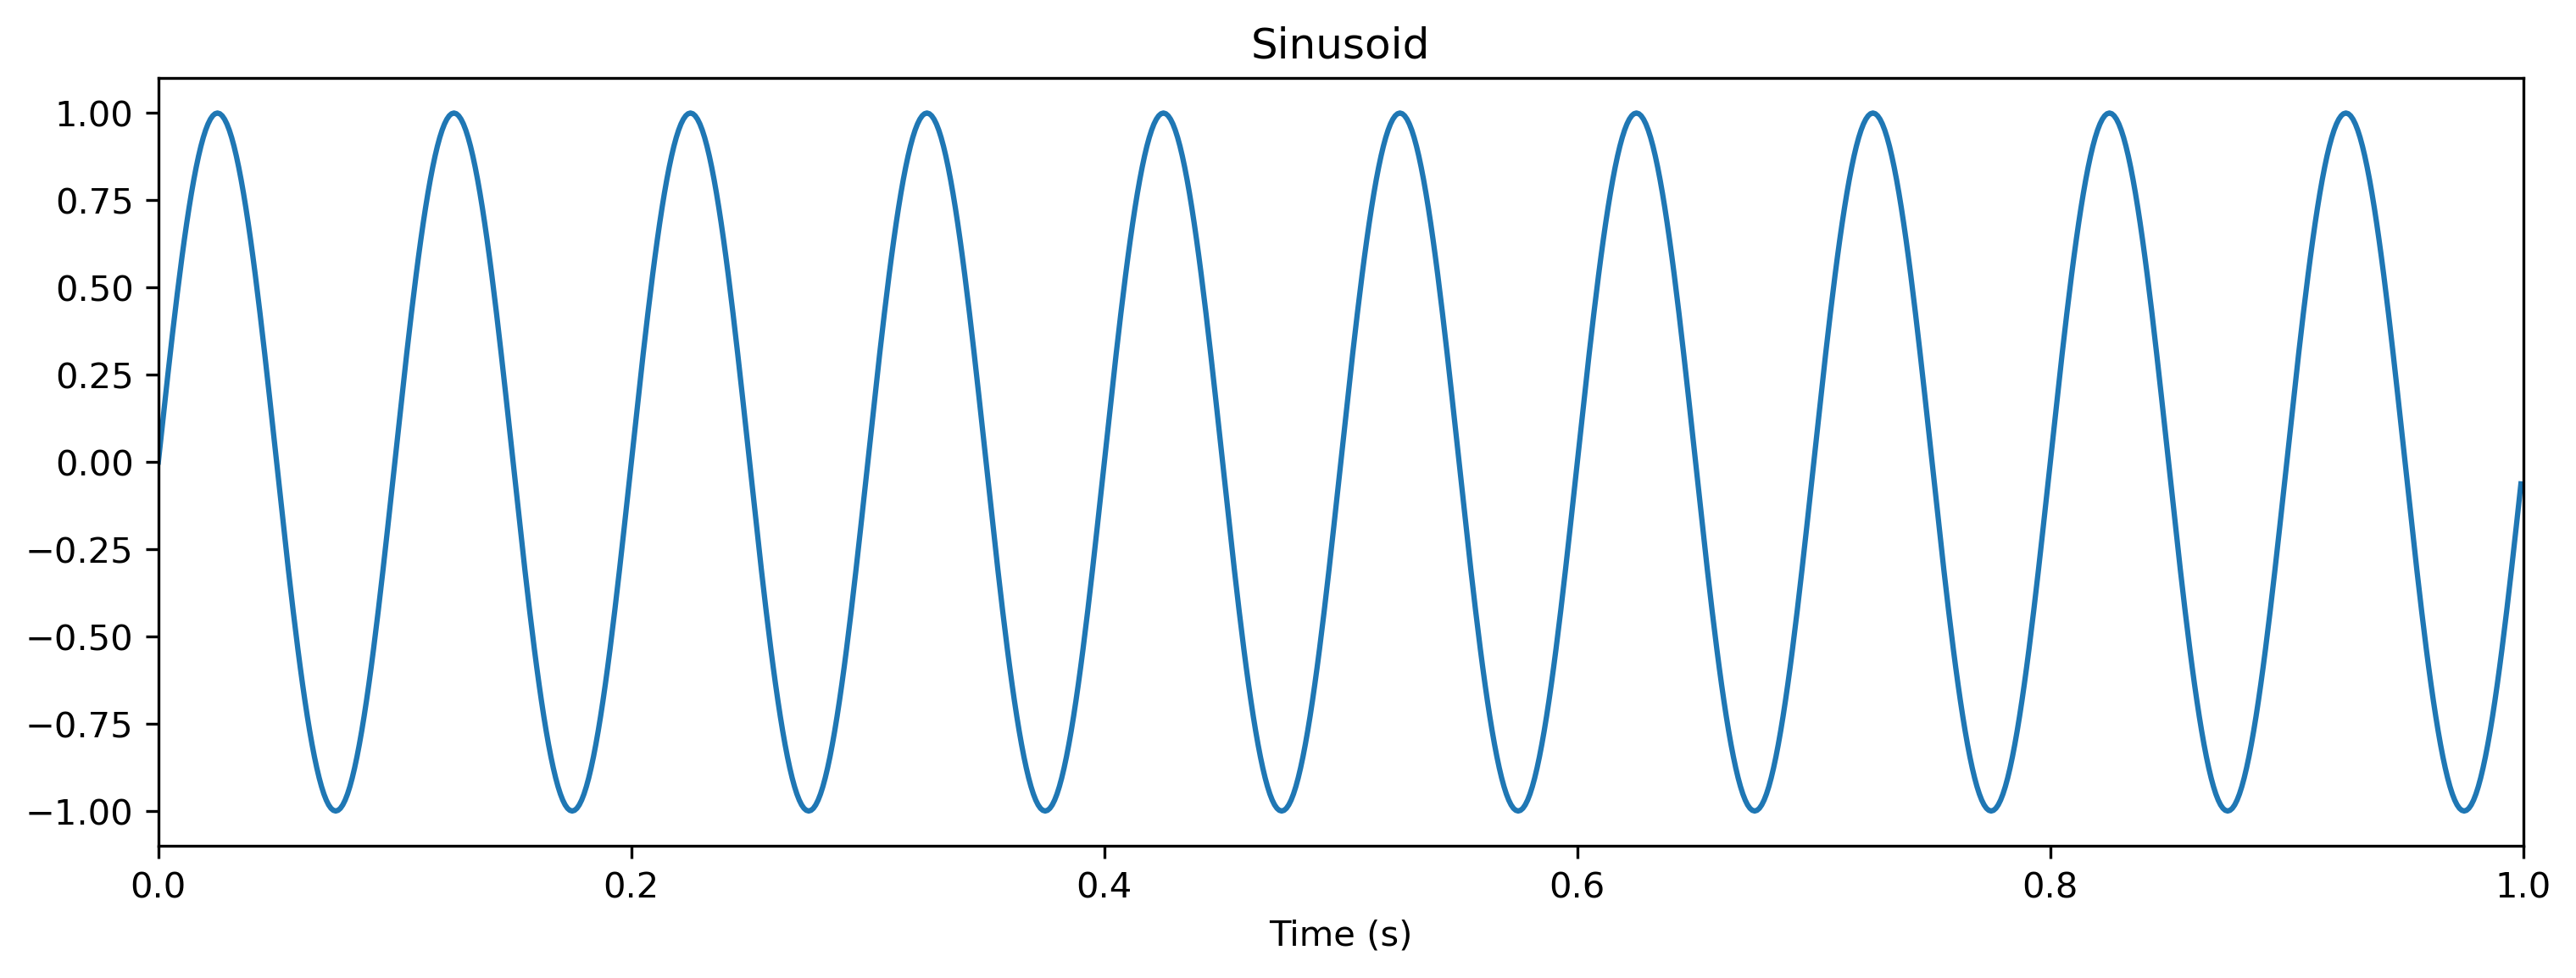

In [2]:
# - Import time-series handling classes
from rockpool import TSContinuous

# - Import and configure matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

# - Create a sinusoidal input signal
T = 1000
omega = 10
time_base = np.arange(T) * dt
ts_sin = TSContinuous.from_clocked(
    np.sin(time_base * 2 * np.pi * omega),
    dt = dt,
    periodic = True,
    name = 'Sinusoid',
)
ts_sin.plot();

non-periodic TSContinuous object `Output samples` from t=0.0 to 1.0. Samples: 1000. Channels:
5

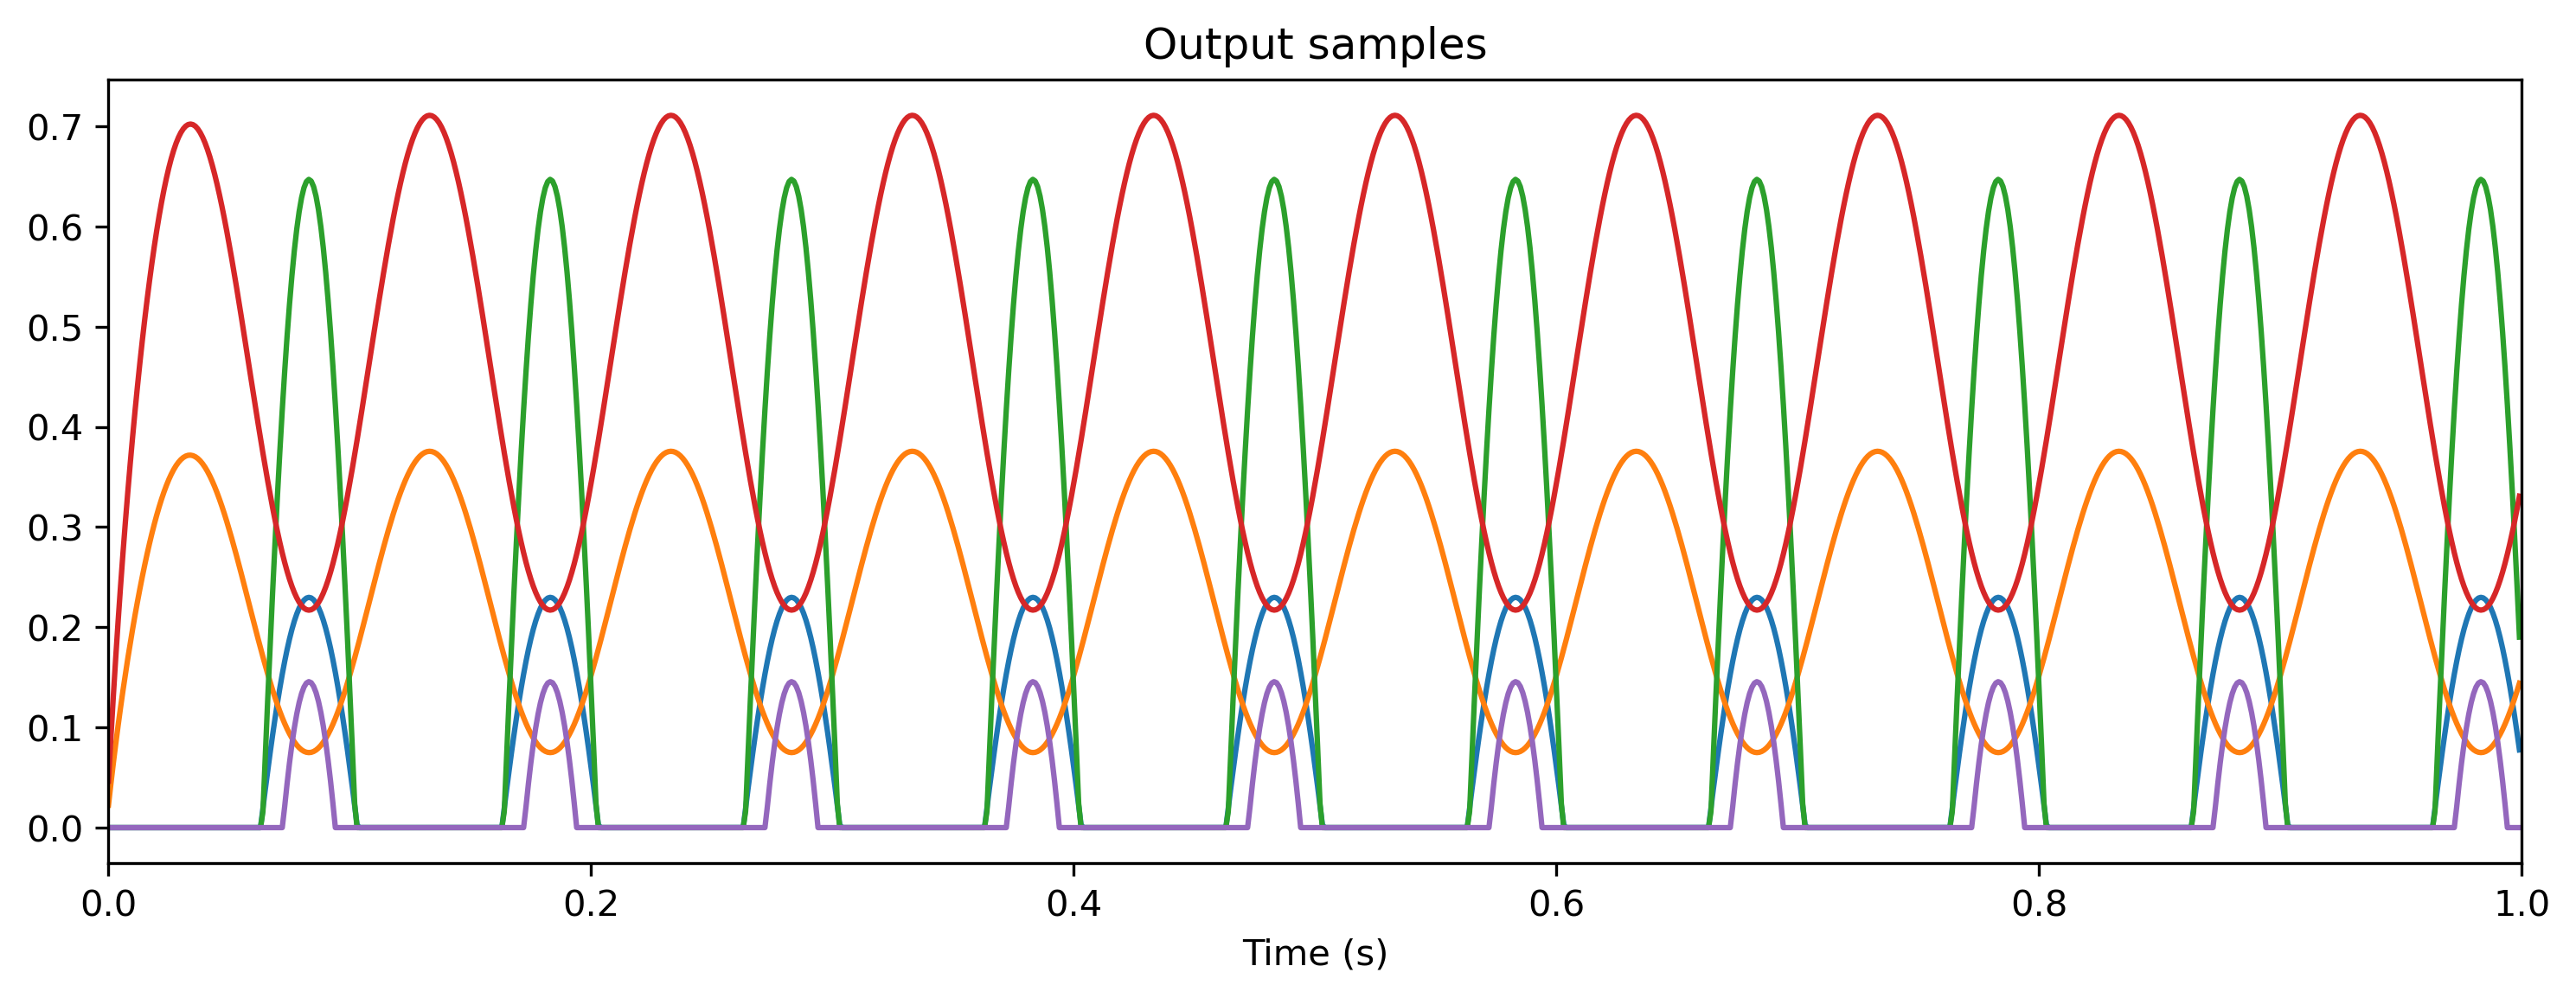

In [3]:
# - Evolve the TimedModule
output_ts, _, _ = tmod(ts_sin)
plt.figure();
print(output_ts);
output_ts.plot();

## Inspecting a `TimedModule`

In [4]:
# - Examine the parameters
print('Parameters:', tmod.parameters())

# - Examine the state
print('State:', tmod.state())

# - Examine the simulation parameters
print('Simulation parameters:', tmod.simulation_parameters())

# - `TimedModules` also have time
print('Time:', tmod.t)

Parameters:
{
    '_module': {
        '0_Linear': {
            'weight': array([[-0.38488846,  0.17506742, -1.15487633,  0.28750642, -0.7514934 
]]),
            'bias': array([-0.10075588,  0.22529542, -0.34495297,  0.46406876, -0.49982842])
        },
        '1_Rate': {
            'tau': array([0.01, 0.01, 0.01, 0.01, 0.01]),
            'bias': array([0., 0., 0., 0., 0.]),
            'threshold': array([0., 0., 0., 0., 0.])
        }
    }
}

State:
{
    '_module': {
        '0_Linear': {},
        '1_Rate': {
            'x': array([ 0.07757606,  0.14418072,  0.1901406 ,  0.33085723, -0.15163591])
        }
    }
}

Simulation parameters:
{
    'dt': 0.001,
    '_module': {
        'dt': 0.001,
        '0_Linear': {},
        '1_Rate': {
            'dt': 0.001,
            'noise_std': 0.0,
            'act_fn': <function H_ReLU at 0x147589670>
        }
    }
}

Time: 1.0

## Building a network using nested `TimedModule` s

In [5]:
# - Import the base class and a TimedModule to use as a submodule
from rockpool.nn.modules import TimedModule
from rockpool.parameters import Parameter
from rockpool.nn.layers import FFRateEuler
from rockpool import TimeSeries

# - Define a new TimedModule
class ffwd_tmod_net(TimedModule):
    # - Provide an `__init__` method to specify required parameters and modules
    #   Here you check, define and initialise whatever parameters and
    #   state you need for your module.
    def __init__(self,
                 shape,
                 *args,
                 **kwargs,
                ):
        # - Call superclass initialisation
        #   This is always required for a `Module` class
        super().__init__(shape = shape, *args, **kwargs)

        # - Specify weights attribute
        #   We need a weights matrix for our input weights.
        #   We specify the shape explicitly, and provide an initialisation function.
        #   We also specify a family for the parameter, "weights". This is used to
        #   query parameters conveniently, and is a good idea to provide.
        self.w_ffwd = Parameter(shape = self.shape[0:2],
                                init_func = lambda s: np.zeros(s),
                                family = 'weights',
                               )
    
        # - Specify and add submodules
        #   These will be the neurons in our layer, to receive the weighted
        #   input signals. This sub-module will be automatically configured
        #   internally, to specify the required state and parameters
        self.neurons1 = FFRateEuler(np.zeros(self.shape[1:3]))
        self.neurons2 = FFRateEuler(np.zeros(self.shape[2:4]))
        
    # - The `evolve` method contains the internal logic of your module
    #   `evolve` takes care of passing data in and out of the module,
    #   and between sub-modules if present.
    def evolve(self,
               ts_input: TimeSeries,
               duration: float,
               num_timesteps: int,
               record: bool = False,
               *args, **kwargs):
        # - Pass input data through the input weights
        x0 = ts_input @ self.w_ffwd
        
        # - Pass the signals through the neurons
        x1, _, _ = self.neurons1(x0)
        x2, _, _ = self.neurons2(x1)
        
        # - Return the module output
        return x2, {}, {}

In [6]:
Nin = 3
Nout = 1
dt = 1

tmod = ffwd_tmod_net((Nin, 5, 7, Nout), dt = dt)
print(tmod)

ffwd_tmod_net  with shape (3, 5, 7, 1) {
    FFRateEuler 'neurons1' with shape (5, 7)
    FFRateEuler 'neurons2' with shape (7, 1)
}

In [7]:
# - Examine the nested parameters of the TimedModule
print(tmod.parameters())

{
    'w_ffwd': array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]]),
    'neurons1': {
        'weights': array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]]),
        'bias': array([0., 0., 0., 0., 0., 0., 0.]),
        'gain': array([1., 1., 1., 1., 1., 1., 1.]),
        'tau': array([10., 10., 10., 10., 10., 10., 10.])
    },
    'neurons2': {
        'weights': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]]),
        'bias': array([0.]),
        'gain': array([1.]),
        'tau': array([10.])
    }
}

In [8]:
# - Set the weights to something non-zero
p = tmod.parameters()
p['w_ffwd'] = np.random.normal(size = p['w_ffwd'].shape) + 1
p['neurons1']['weights'] = np.random.normal(size = p['neurons1']['weights'].shape) + 1
p['neurons2']['weights'] = np.random.normal(size = p['neurons2']['weights'].shape) + 1

# - Assign the new parameters
tmod.set_attributes(p)
print('Weights:', tmod.parameters())

Weights:
{
    'w_ffwd': array([[ 0.86735526,  1.09941143,  1.68307637,  0.7059919 ,  2.21638427],
       [ 1.88577272,  1.24852655,  1.10845428,  0.78676224, -0.15133575],
       [ 2.23002304,  0.91619861,  1.87662398, -0.58973472,  1.25997604]]),
    'neurons1': {
        'weights': array([[ 0.34402393,  1.94181954, -0.16545552,  0.85101429,  1.35841288,
         2.04718191,  1.18040996],
       [ 0.47202964,  0.7172136 , -0.67234282,  0.13556761,  1.56249056,
         1.59492832, -0.81611213],
       [ 2.0803491 ,  0.42232506,  0.6279111 ,  2.21954628,  2.12207695,
        -0.41136589,  0.68032866],
       [ 0.97695692,  1.54085101,  1.24947378,  0.30461951,  0.42379403,
        -0.43296679,  0.96987412],
       [ 0.04296639,  1.04277267, -0.94048266,  1.13638566,  1.85915138,
         1.31471222,  2.38510698]]),
        'bias': array([0., 0., 0., 0., 0., 0., 0.]),
        'gain': array([1., 1., 1., 1., 1., 1., 1.]),
        'tau': array([10., 10., 10., 10., 10., 10., 10.])
    },
    'neurons2': {
        'weights': array([[1.3367682 ],
       [3.87244525],
       [2.02491768],
       [2.0701165 ],
       [0.74854559],
       [2.25983614],
       [1.5709338 ]]),
        'bias': array([0.]),
        'gain': array([1.]),
        'tau': array([10.])
    }
}

Input: periodic TSContinuous object `White noise` from t=0.0 to 1000.0. Samples: 1000. 
Channels: 3

Output: non-periodic TSContinuous object `Outputs` from t=0.0 to 1000.0. Samples: 1001. 
Channels: 1

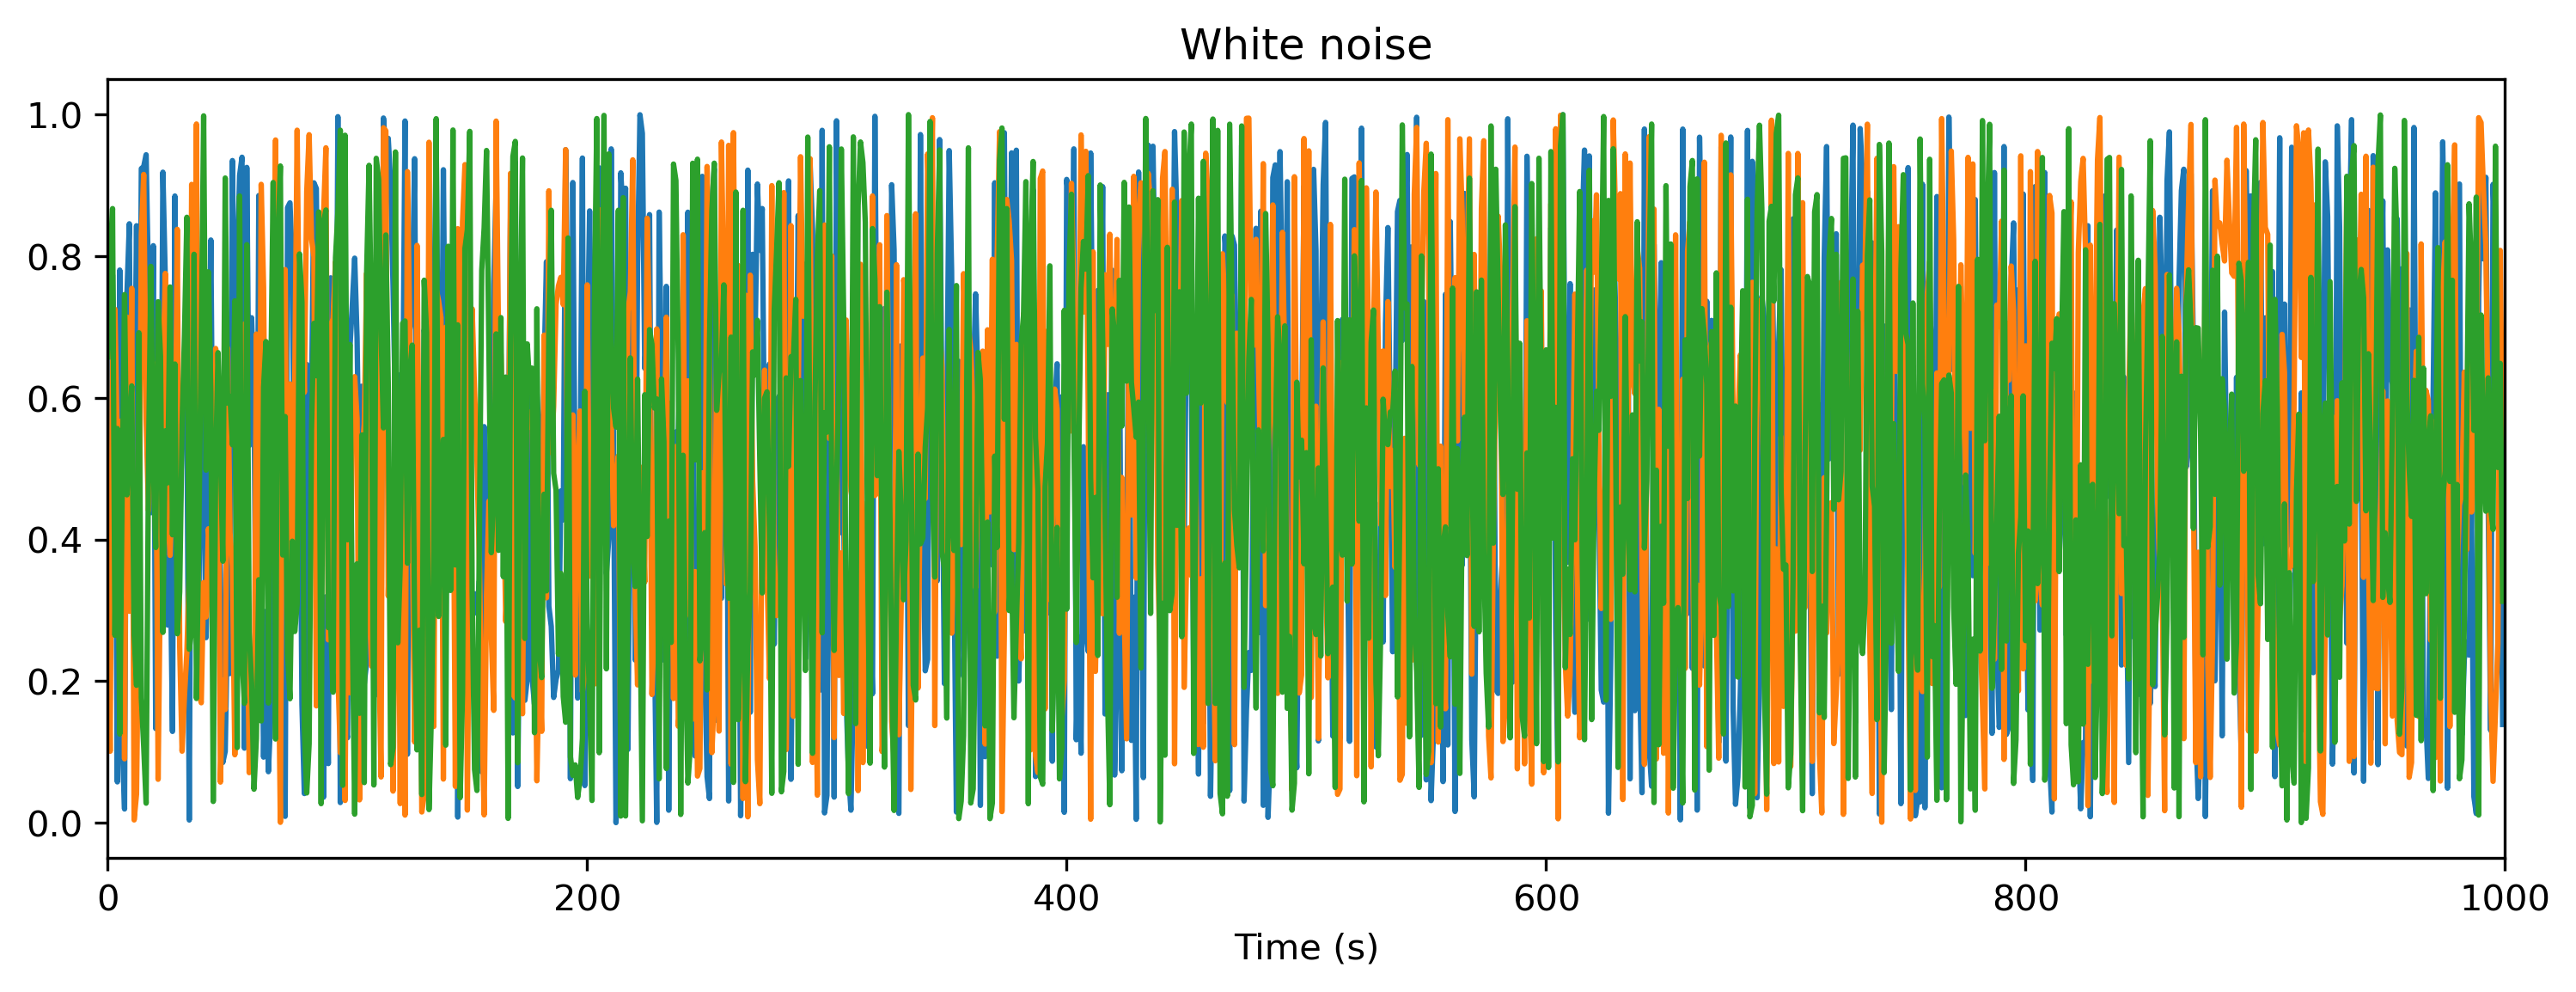

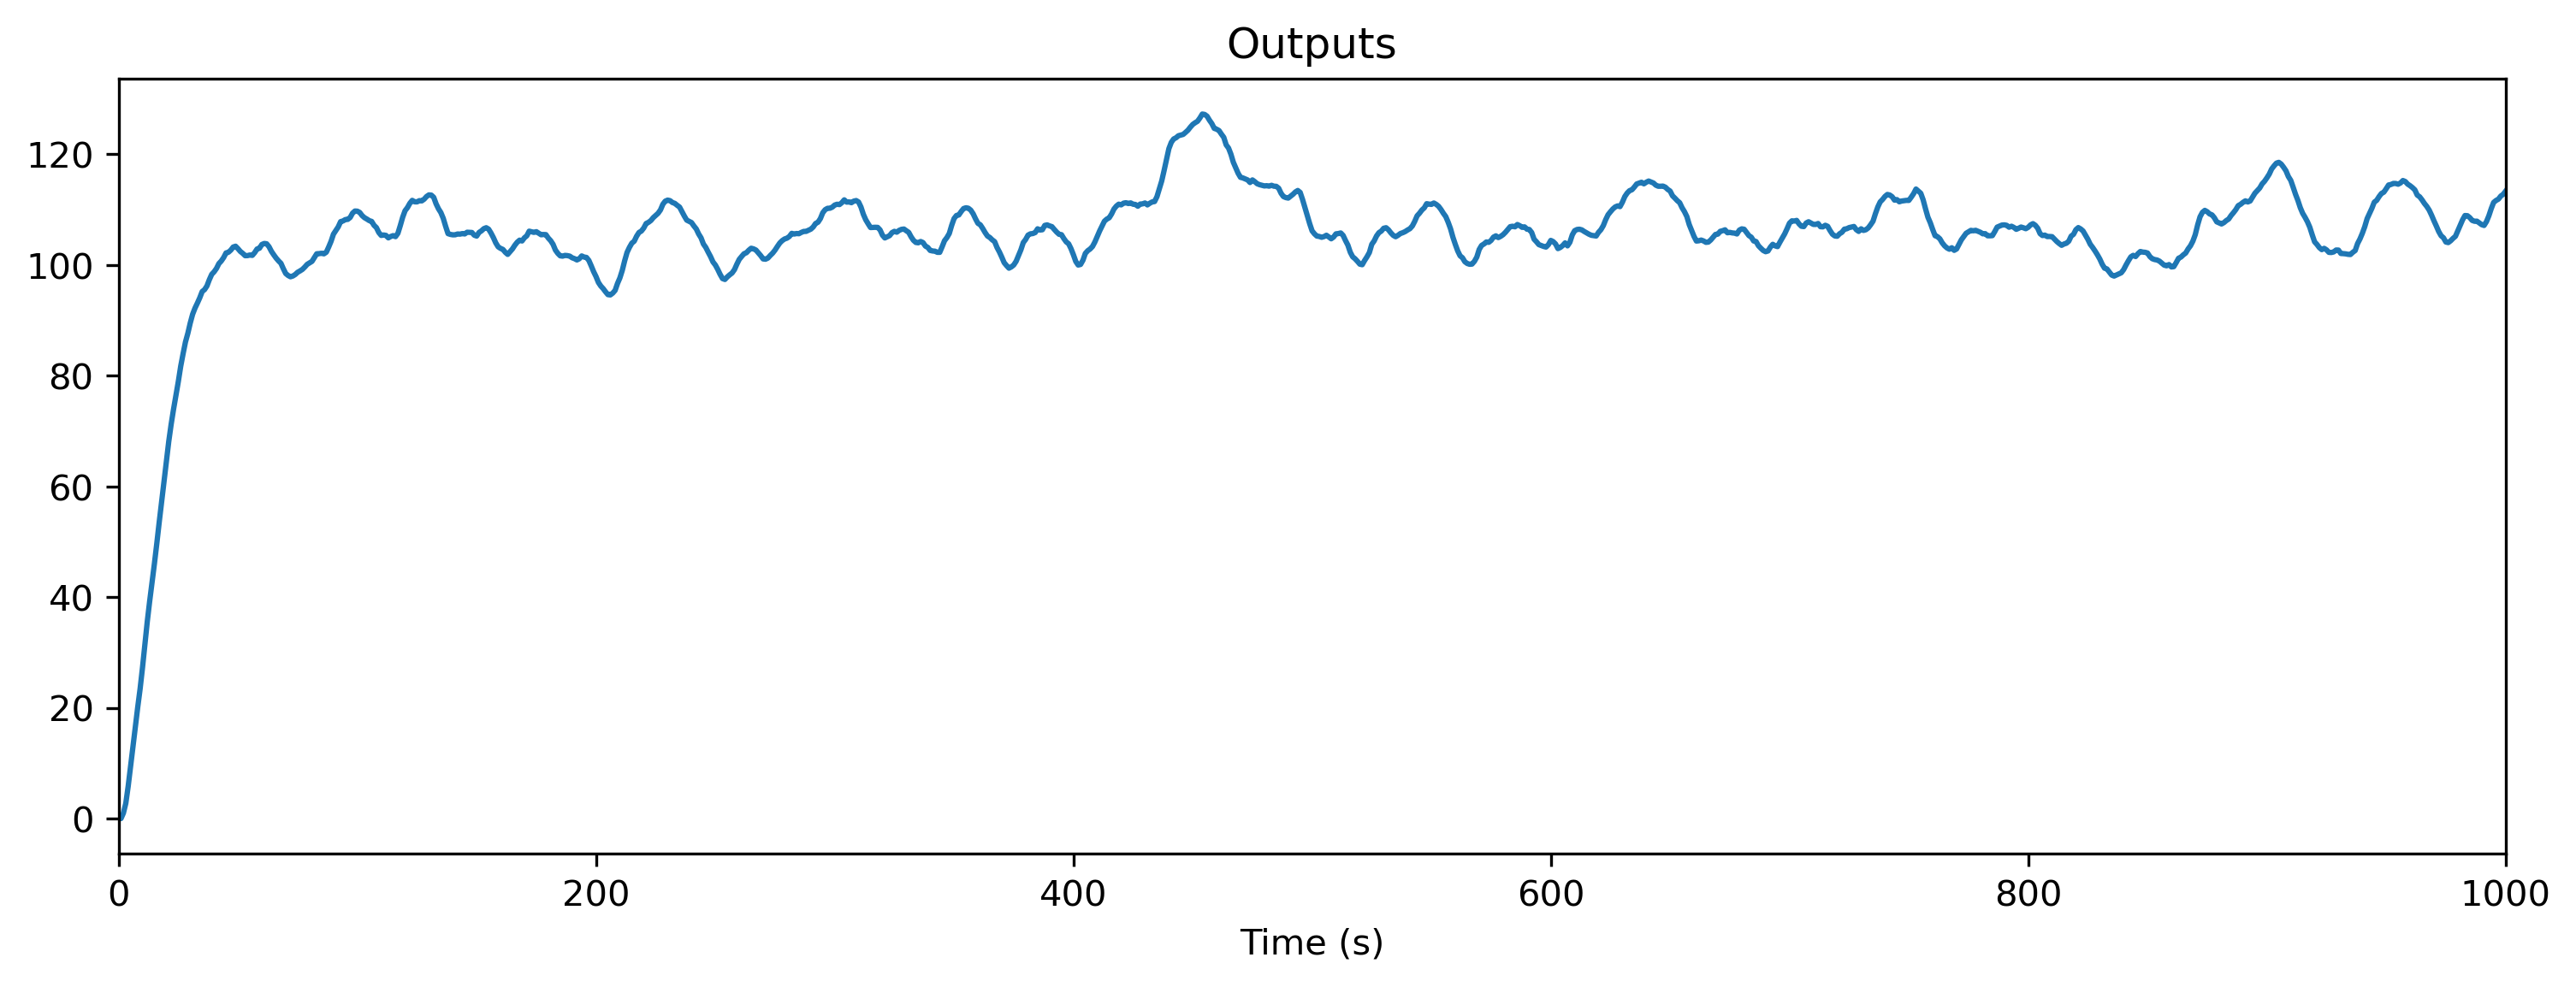

In [9]:
# - Generate some white noise input
ts_input = TSContinuous.from_clocked(np.random.rand(1000, Nin),
                                     name = 'White noise',
                                     dt = dt, periodic = True,
                                    )
print('Input:', ts_input)
ts_input.plot()

# - Evolve the TimedModule with the input
ts_output, _, rec = tmod(ts_input)

# - Display the output
print('Output:', ts_output)
plt.figure()
ts_output.plot();

## Building a network using internal `Module` s

In [10]:
# - Import the base class and a Module to use as a submodule
from rockpool.nn.modules import TimedModule
from rockpool.parameters import Parameter
from rockpool.nn.modules import RateJax
from rockpool import TimeSeries

# - Define a new TimedModule
class ffwd_tmod_net2(TimedModule):
    # - Provide an `__init__` method to specify required parameters and modules
    #   Here you check, define and initialise whatever parameters and
    #   state you need for your module.
    def __init__(self,
                 shape,
                 *args,
                 **kwargs,
                ):
        # - Call superclass initialisation
        #   This is always required for a `Module` class
        super().__init__(shape = shape, *args, **kwargs)

        # - Specify weights attributes
        #   We need weights matrices for our layer weights.
        #   We specify the shapes explicitly, and provide an initialisation function.
        #   We also specify a family for the parameter, "weights". This is used to
        #   query parameters conveniently, and is a good idea to provide.
        self.w0 = Parameter(shape = self.shape[0:2],
                            init_func = lambda s: np.zeros(s),
                            family = 'weights',
                            )

        self.w1 = Parameter(shape = self.shape[1:3],
                            init_func = lambda s: np.zeros(s),
                            family = 'weights',
                            )
        
        # - Specify and add submodules
        #   These will be the neurons in our layer, to receive the weighted
        #   input signals. These sub-modules will be automatically configured
        #   internally, to specify the required state and parameters
        self.neurons0 = RateJax(self.shape[1])
        self.neurons1 = RateJax(self.shape[2])
        
    # - The `evolve` method contains the internal logic of your module
    #   `evolve` takes care of passing data in and out of the module,
    #   and between sub-modules if present.
    def evolve(self,
               ts_input: TimeSeries,
               duration: float,
               num_timesteps: int,
               record: bool = False,
               *args, **kwargs):
        # - First we need to rasterise the input time series.
        #   We can use the convenience method `_prepare_input()` for this
        time_base, input_raster, num_timesteps = self._prepare_input(
            ts_input, duration, num_timesteps
        )
        
        # - Pass input data through the input weights
        x0 = input_raster @ self.w0
        
        # - Pass the signals through the neurons
        x1, _, _ = self.neurons0(x0)
        
        # - Second layer weights
        x2 = x1 @ self.w1
        
        # - Second layer neurons
        x3, _, _ = self.neurons1(x2)
        
        # - We need to re-wrap the output raster as a TimeSeries object
        #   To do this we can use the convenience method `_gen_timeseries()`
        output_ts = self._gen_timeseries(x3)
        
        # - Return the module output
        return output_ts, {}, {}

In [11]:
# - Instantiate the module
tmod = ffwd_tmod_net2((Nin, 5, 7, Nout), dt = dt)
print(tmod)

ffwd_tmod_net2  with shape (3, 5, 7, 1) {
    RateJax 'neurons0' with shape (5,)
    RateJax 'neurons1' with shape (7,)
}

Input: periodic TSContinuous object `White noise` from t=0.0 to 1000.0. Samples: 1000. 
Channels: 3

Output: non-periodic TSContinuous object `Output samples` from t=0.0 to 1000.0. Samples: 
1000. Channels: 7

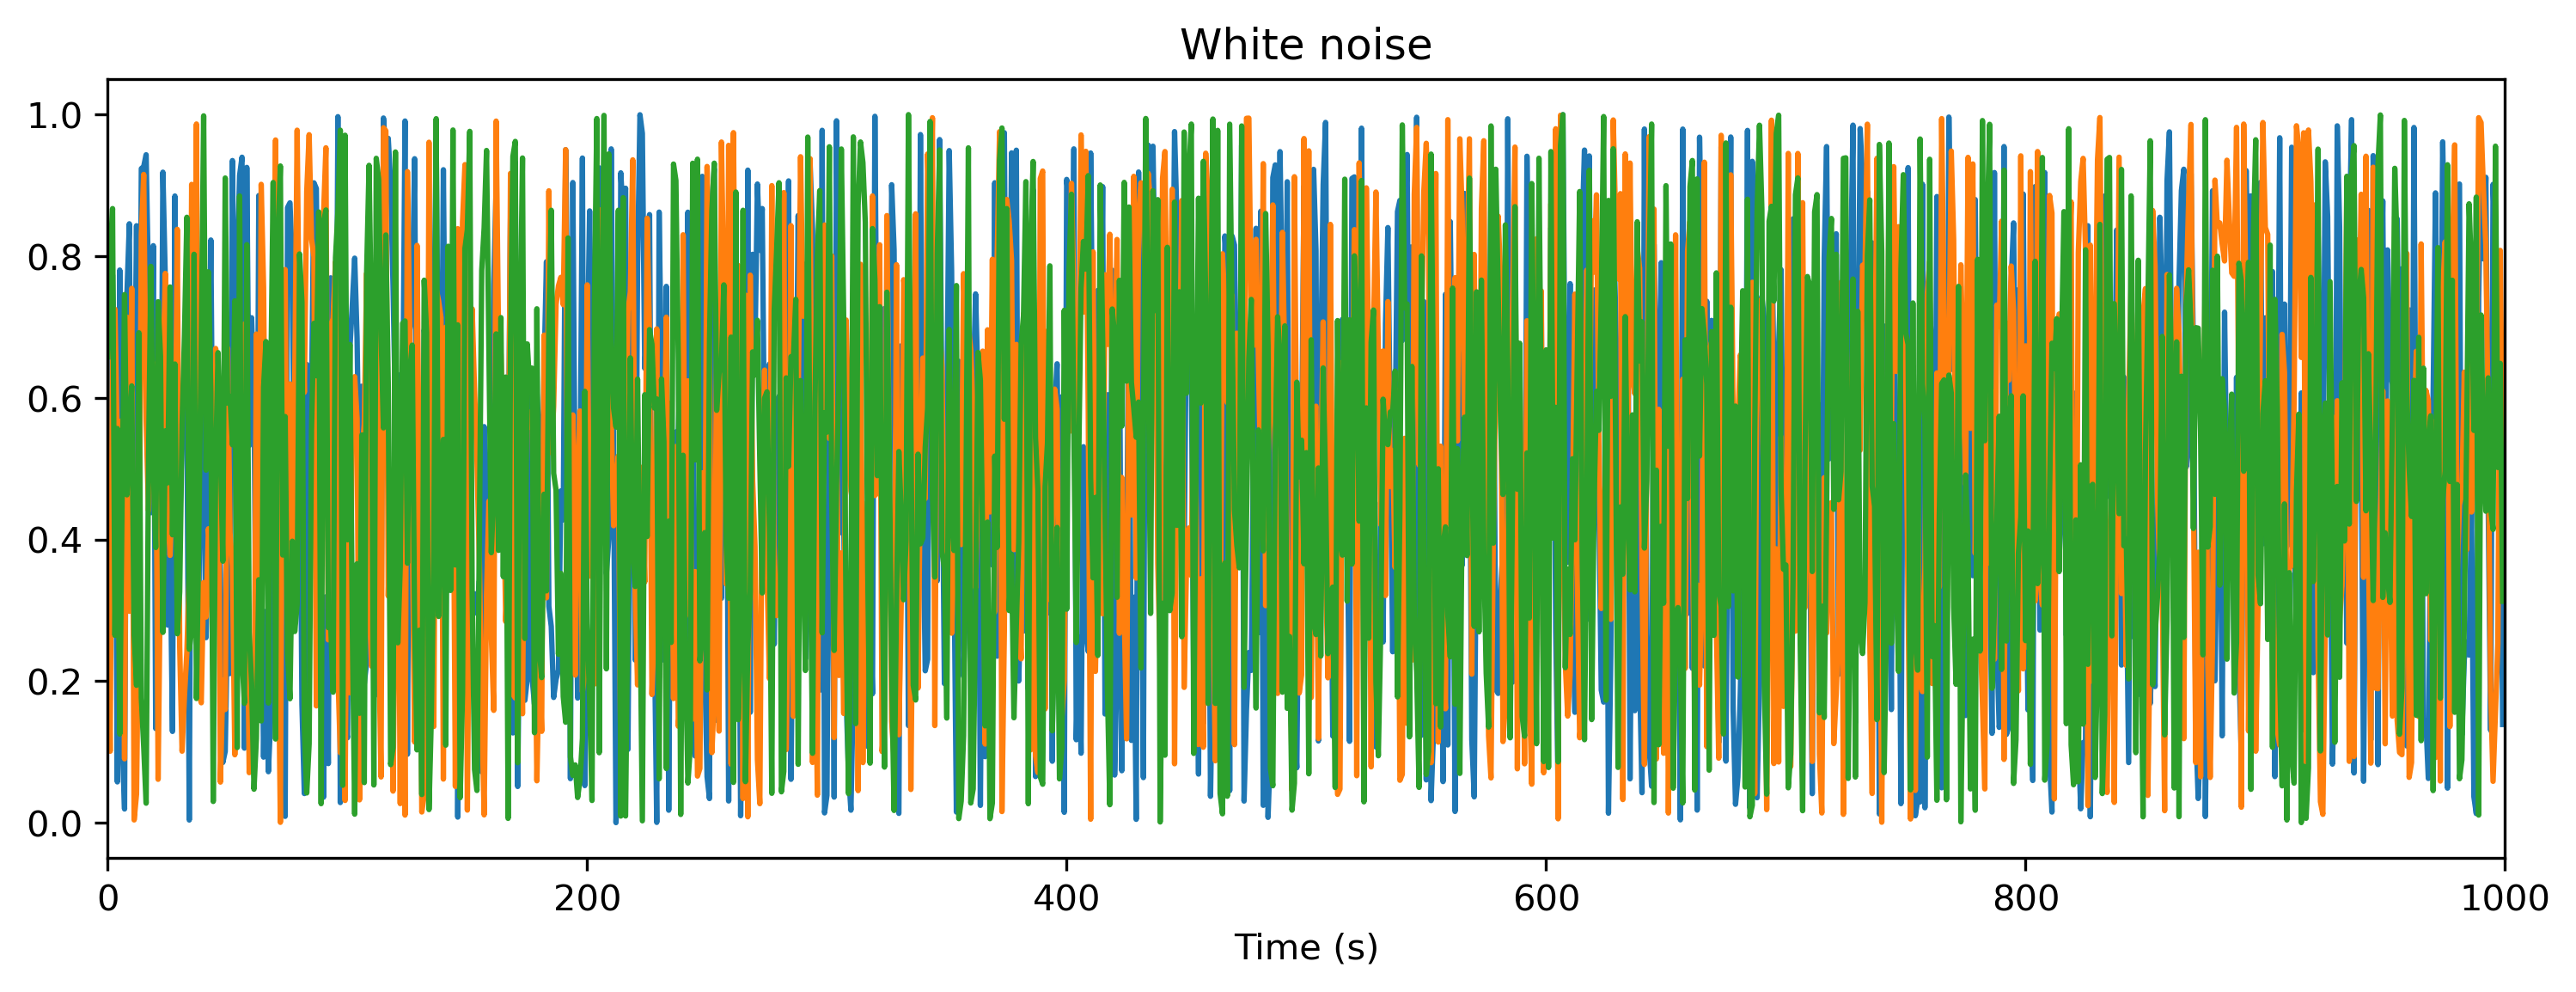

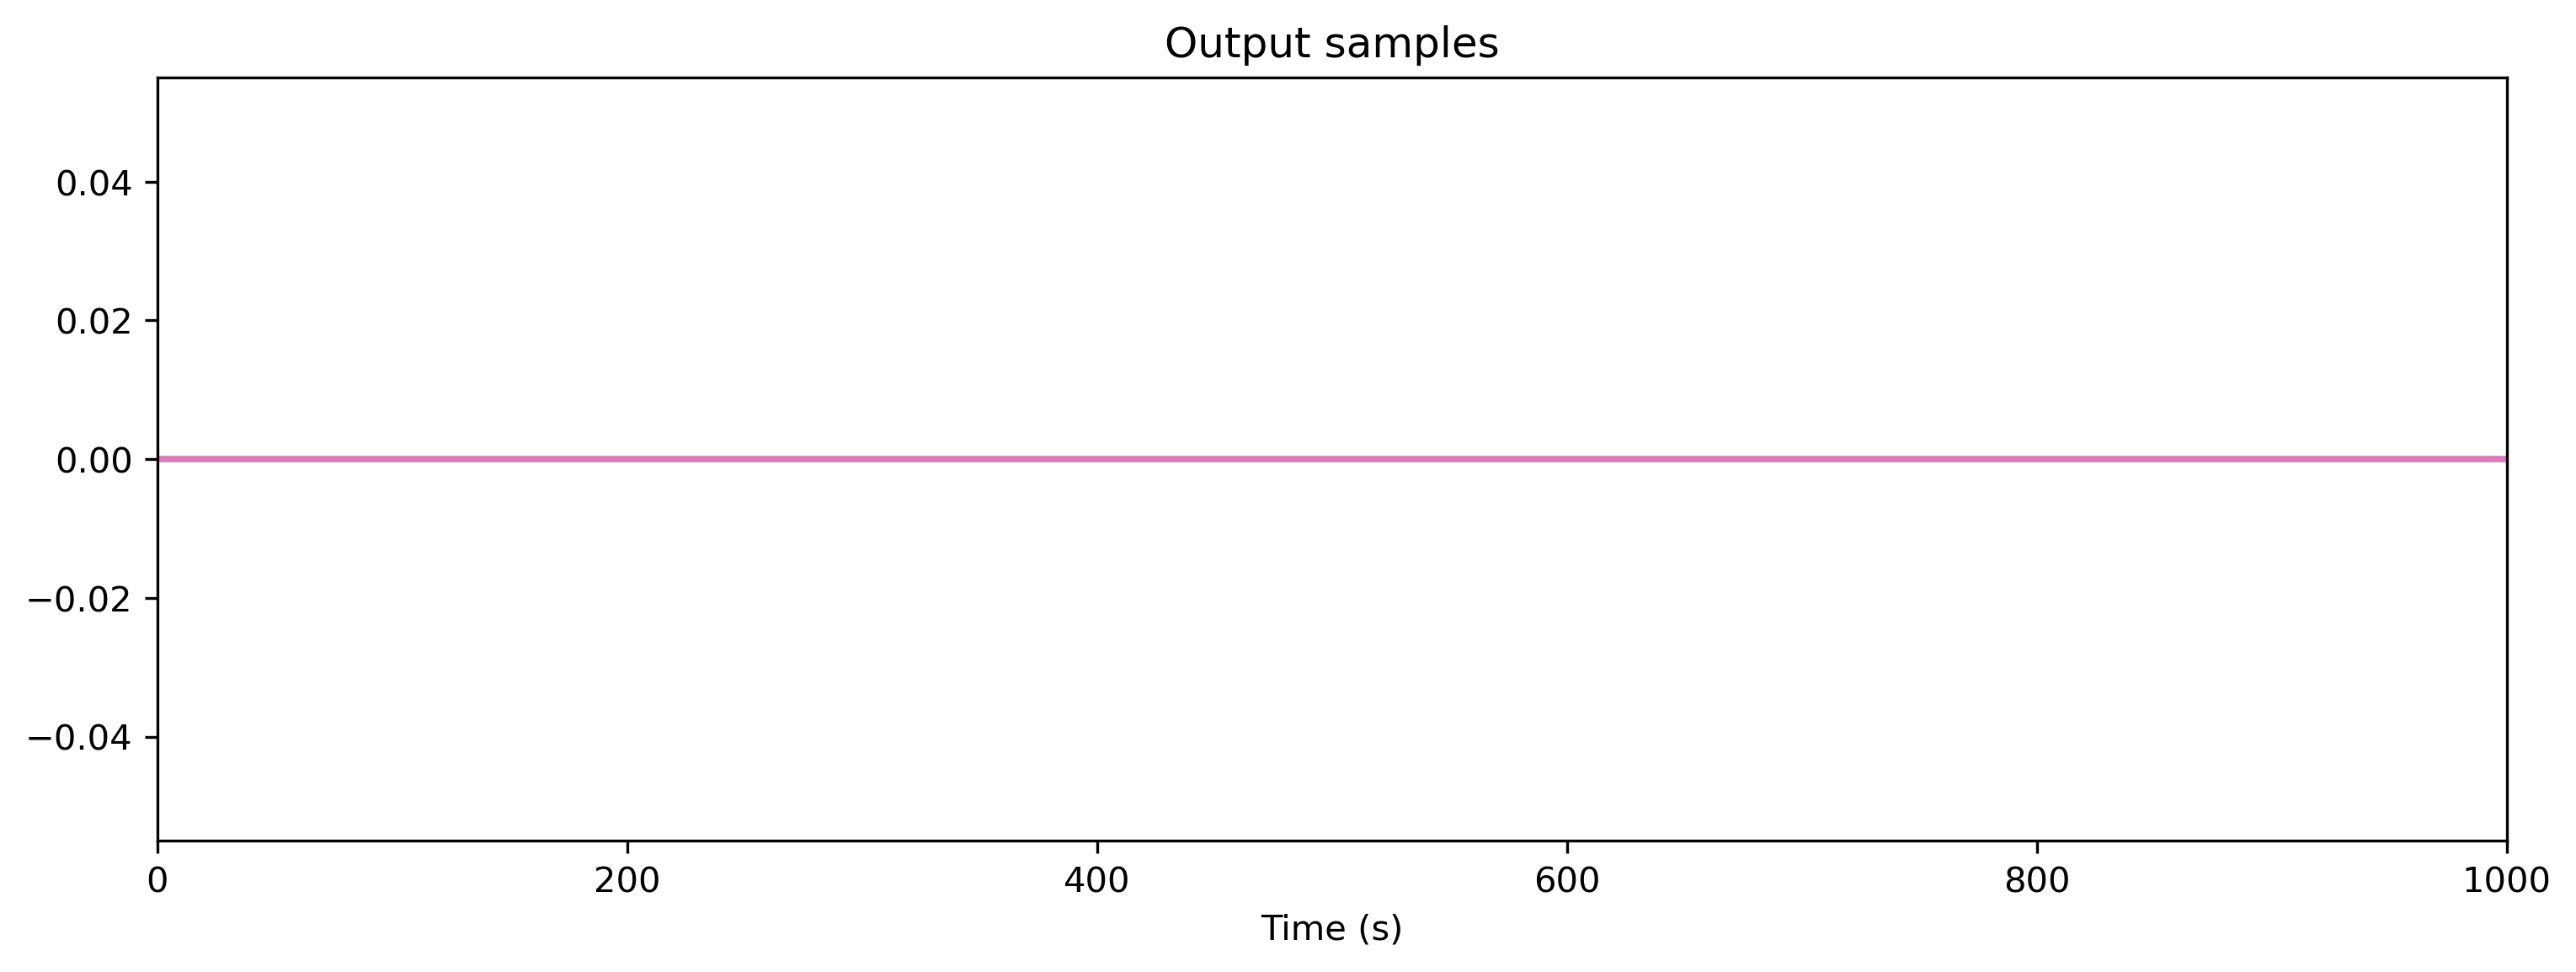

In [12]:
print('Input:', ts_input)
ts_input.plot()

# - Evolve the TimedModule with the input
ts_output, _, rec = tmod(ts_input)

# - Display the output
print('Output:', ts_output)
plt.figure()
ts_output.plot();

## Converting a low-level API `Module` to a high-level API `TimedModule`

In [13]:
# - Import the converter class
from rockpool.nn.modules.timed_module import TimedModuleWrapper
from rockpool.nn.modules import RateJax

# - Generate a module and wrap as a TimedModule
mod = RateJax(4)
tmod = TimedModuleWrapper(mod)
print(tmod)

TimedModuleWrapper  with shape (4, 4) {
    RateJax '_module' with shape (4,)
} with RateJax '_module' as module

In [14]:
# - Use the conversion method
from rockpool.nn.modules import RateJax

# - Generate a module and wrap as a TimedModule
tmod = RateJax(4).timed()
print(tmod)

TimedModuleWrapper  with shape (4, 4) {
    RateJax '_module' with shape (4,)
} with RateJax '_module' as module

## `TimedModule` API reference

### High-level attributes and methods provided by `TimedModule`

### Low-level attributes and methods inherited from `Module`